In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from datetime import datetime


import warnings
warnings.filterwarnings("ignore")

In [53]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter



In [4]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [9]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(),  
    download = True           
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

9913344it [00:00, 19198989.71it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



29696it [00:00, 13980699.47it/s]         

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




1649664it [00:00, 12052788.17it/s]                           


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



5120it [00:00, 4683715.70it/s]          

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [17]:
print(train_data)
print()
print(test_data)
print()
print()
print("training data shape:\t", train_data.data.shape)
print("test data shape:\t", test_data.data.shape)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


training data shape:	 torch.Size([60000, 28, 28])
test data shape:	 torch.Size([10000, 28, 28])


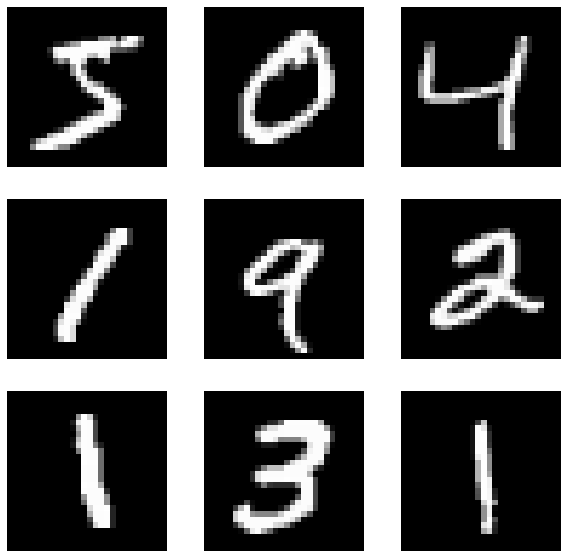

In [20]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    ax = fig.add_subplot(330 + 1 + i)
    ax.axis("off")
    ax.imshow(train_data.data[i], cmap="gray")
    
plt.show()

In [21]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x15aacefd0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x15aaced60>}

Feature batch shape: torch.Size([100, 1, 28, 28])
Labels batch shape: torch.Size([100])


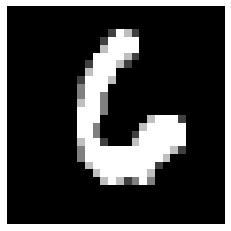

Label: 6


In [34]:
# use DataLoader to randomly pick batches of data
train_features, train_labels = next(iter(loaders["train"]))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()
print(f"Label: {label}")

In [69]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,              
                out_channels=64,            
                kernel_size=3,              
                stride=1,                   
                padding=0,                  
            ),   
            nn.ReLU(),                                      
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(
                in_channels=64,              
                out_channels=64,            
                kernel_size=3,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        # fully connected layer, output 10 classes
        self.dense = nn.Linear(64 * 5 * 5, 100)
        self.out = nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten the output of conv3 to (batch_size, n_neurons)
        x = x.view(x.size(0), -1) 
        x = self.dense(x)      
        output = self.out(x)
        return output, x    # return x for visualization
    

In [75]:
model = CNN()
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Linear(in_features=1600, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=10, bias=True)
)


In [76]:
loss_fn = nn.CrossEntropyLoss()   
optimizer = optim.Adam(model.parameters(), lr = 0.01)   


def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(loaders["train"]):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print(f'  batch {i + 1} loss: {last_loss}')
            tb_x = epoch_index * len(loaders["train"]) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/fashion_trainer_{timestamp}')
EPOCHS = 5

best_vloss = 1_000_000.

for epoch_number, _ in enumerate(range(EPOCHS)):
    print(f'EPOCH {epoch_number + 1}:')

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print(f'LOSS train {avg_loss} valid {avg_vloss}')

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_{timestamp}_{epoch_number}'
        torch.save(model.state_dict(), model_path)

In [73]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  CNN.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in enumerate(loaders):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=CNN(images)

      loss = loss_func(outputs,labels)
      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss=running_loss/len(loaders)
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 